In [1]:
import syft as sy
from utils import *

/home/e/anaconda3/envs/Hagrid/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TissueMNIST-e6916fbe07ec4302be04779d346e8a94.pkl is already downloaded
Columns: Index(['patient_ids', 'images', 'labels'], dtype='object')
Total Images: 2363
Label Mapping {'Collecting Duct, Connecting Tubule': 0, 'Distal Convoluted Tubule': 1, 'Glomerular endothelial cells': 2, 'Interstitial endothelial cells': 3, 'Leukocytes': 4, 'Podocytes': 5, 'Proximal Tubule Segments': 6, 'Thick Ascending Limb': 7}


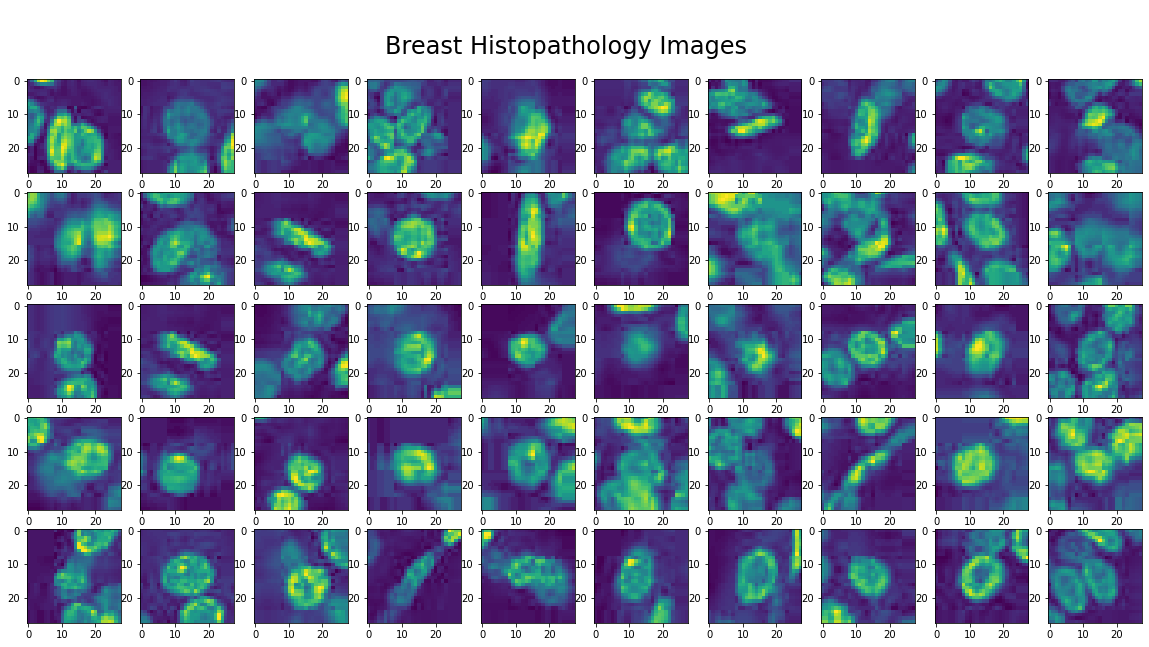

In [2]:
MY_DATASET_URL = "https://raw.githubusercontent.com/OpenMined/datasets/main/TissueMNIST/subsets/TissueMNIST-e6916fbe07ec4302be04779d346e8a94.pkl"
dataset = download_dataset(MY_DATASET_URL)

In [3]:
dataset.head()

,patient_ids,images,labels
0,55614,"[[18, 24, 65, 110, 113, 90, 74, 68, 43, 29, 14...",4
1,55614,"[[5, 6, 9, 12, 10, 9, 15, 24, 33, 28, 28, 31, ...",1
2,55614,"[[15, 11, 10, 11, 10, 6, 6, 9, 9, 11, 12, 12, ...",5
3,55614,"[[6, 5, 5, 5, 5, 5, 4, 4, 8, 7, 6, 5, 5, 6, 6,...",7
4,55614,"[[31, 14, 13, 18, 11, 7, 13, 18, 11, 11, 12, 1...",0


In [4]:
# run this cell
train, val, test = split_and_preprocess_dataset(data=dataset)

Splitting dataset into train, validation and test sets.
Preprocessing the dataset...
Dims (1907, 3, 50, 50)
Dims (243, 3, 50, 50)
Dims (213, 3, 50, 50)
Preprocessing completed.


In [5]:
# run this cell
data_subjects = DataSubjectList.from_series(train["patient_ids"])
train_image_data = sy.Tensor(train["images"]).annotated_with_dp_metadata(
    min_val=0, max_val=255, data_subjects=data_subjects
)
train_label_data = sy.Tensor(train["labels"]).annotated_with_dp_metadata(
    min_val=0, max_val=1, data_subjects=data_subjects
)

Tensor annotated with DP Metadata
Tensor annotated with DP Metadata


In [6]:
data_subjects = DataSubjectList.from_series(val["patient_ids"])
val_image_data = sy.Tensor(val["images"]).annotated_with_dp_metadata(
    min_val=0, max_val=255, data_subjects=data_subjects
)
val_label_data = sy.Tensor(val["labels"]).annotated_with_dp_metadata(
    min_val=0, max_val=1, data_subjects=data_subjects
)

Tensor annotated with DP Metadata
Tensor annotated with DP Metadata


In [7]:
data_subjects = DataSubjectList.from_series(test["patient_ids"])
test_image_data = sy.Tensor(test["images"]).annotated_with_dp_metadata(
    min_val=0, max_val=255, data_subjects=data_subjects
)
test_label_data = sy.Tensor(test["labels"]).annotated_with_dp_metadata(
    min_val=0, max_val=1, data_subjects=data_subjects
)

Tensor annotated with DP Metadata
Tensor annotated with DP Metadata


### Model Training

In [8]:
from syft import nn

In [9]:
input_shape = train_image_data.public_shape
input_shape

(1907, 3, 50, 50)

In [10]:
y_train = train_label_data

In [11]:
model = nn.Model()

# Layer 1
model.add(nn.Convolution(nb_filter=32, filter_size=3, padding=2, input_shape=input_shape))
model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
model.add(nn.MaxPool(pool_size=2, stride=2))

# Layer 2
model.add(nn.Convolution(nb_filter=64, filter_size=3, padding=2))
model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
model.add(nn.MaxPool(pool_size=2, stride=2))

# Layer 3
model.add(nn.Convolution(nb_filter=128, filter_size=3, padding=2))
model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
model.add(nn.MaxPool(pool_size=2, stride=2))

# Layer 4
model.add(nn.Convolution(nb_filter=256, filter_size=3, padding=2))
model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
model.add(nn.MaxPool(pool_size=2, stride=2))

# Layer 5
model.add(nn.Convolution(nb_filter=512, filter_size=3, padding=2))
model.add(nn.BatchNorm(activation=nn.leaky_ReLU()))
model.add(nn.MaxPool(pool_size=2, stride=2))

# Layer 6
model.add(nn.AvgPool(7))

# Layer 7
model.add(nn.Flatten())

# Layer 8
model.add(nn.Linear(2, 512))

In [12]:
model.compile()

In [13]:
train_image_data.child.shape, train_image_data.child.data_subjects.shape

((1907, 3, 50, 50), (1907,))

In [14]:
from syft import PhiTensor
def correct_dsl(input_tensor: PhiTensor):
    """ Corrects for the new DSL shape requirements 
    e.g. (1915,) -> (1915, 3, 50, 50) 
    """
    output_dsi = np.ones(input_tensor.shape)  # b/c PhiTensor
    for i in range(input_tensor.shape[0]):
         output_dsi[i] *= input_tensor.data_subjects.data_subjects_indexed[i]
    input_tensor.data_subjects.data_subjects_indexed = output_dsi

correct_dsl(train_image_data.child)  
# .shape, train_image_data.child.data_subjects.shape

In [15]:
train_image_data.child.shape, train_image_data.child.data_subjects.shape

((1907, 3, 50, 50), (1907, 3, 50, 50))

In [16]:
model.fit(train_image_data.child, train_label_data.child, shuffle=False, max_iter=1)

Starting dp pad
done dp_pad (64, 3, 54, 54)
Got out_h, out_w
Done repeat
done tile
done stride * repeat
done tile
done stride * tile
done reshape + reshape
got k
done get_im2col
got cols
transposed!
Done with CONV forward pass
Done with BN forward pass
Starting im2col
Starting dp pad
done dp_pad (2048, 1, 52, 52)
Got out_h, out_w
Done repeat
done tile
done stride * repeat
done tile
done stride * tile
done reshape + reshape
got k
done get_im2col
got cols
transposed!
FInished im2col, starting _argmax
Finished argmax, getting outputs


ValueError: negative dimensions are not allowed